In [1]:
import sys
sys.path.append('..')

import torch
import torchvision.transforms as transforms
from src.utils.get_model_and_data import get_model_and_data
from src.utils.collate_fn_coco import collate_fn_coco
from src.parser.training import parser

import clip

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
parameters = {'device': 'cuda', 'num_attentionLayer': 4, 'overfit': False}
model, datasets = get_model_and_data(parameters)

cat_texts = [v for k, v in datasets['train'].cats.items()]

loading annotations into memory...
Done (t=18.93s)
creating index...
index created!
loading annotations into memory...
Done (t=1.39s)
creating index...
index created!
train set scale: 21391
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
val set scale: 925
Total params: 178.09M
Trainable params: 26.82M


In [3]:
# checkpoint = torch.load('../checkpoint/boxclip-finetune-coslr/checkpoint-epoch100.pth.tar')
# checkpoint = torch.load('../checkpoint/boxclip-one-cap-0806/checkpoint-epoch135.pth.tar')
checkpoint = torch.load('../checkpoint/overfit-100-sample-4-layer/checkpoint-epoch10000.pth.tar')
# checkpoint = torch.load('../checkpoint/boxclip-one-cap/checkpoint-epoch50.pth.tar')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [4]:
dataloader = iter(torch.utils.data.DataLoader(datasets['train'], batch_size=20, shuffle=False, collate_fn=collate_fn_coco))
batch = next(dataloader)
# batch = next(dataloader)
# batch = next(iter(dataloader))
for k, v in batch.items():
    if torch.is_tensor(v): batch[k] = batch[k].to('cuda')
        
model.eval()
with torch.no_grad():
    batch = model(batch)
out_cats = model.feat2cat(batch, cat_texts)

# [[cat_texts[j.item()] for j in i] for i in out_cats]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

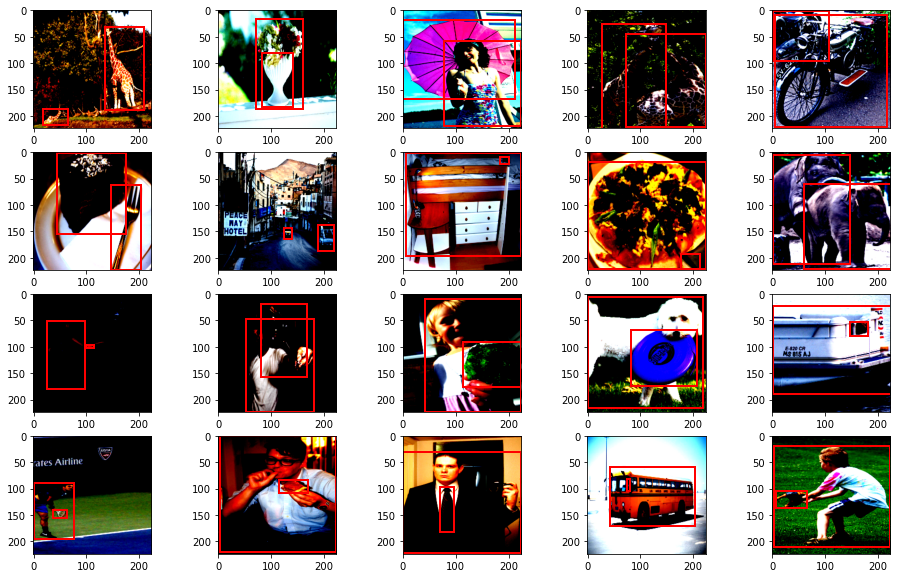

In [5]:
# show some data point
# batch = next(iter(dataloader))

plt.figure(figsize=(16,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(batch['clip_images'][i].permute(1,2,0).cpu())
    for j in range(batch['bboxs'].shape[1]):
        [bbox_x, bbox_y, bbox_w, bbox_h] = batch['bboxs'][i][j]
        plt.gca().add_patch(plt.Rectangle((bbox_x*224, bbox_y*224), bbox_w*224, bbox_h*224, 
                                          fill=False, edgecolor='r', linewidth=2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

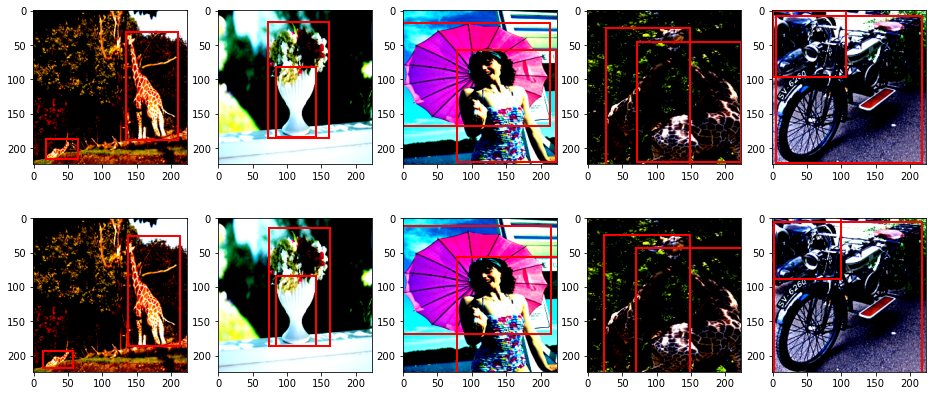

In [6]:
# reconstruction
# batch = next(iter(dataloader))
for k, v in batch.items():
    if torch.is_tensor(v): batch[k] = batch[k].to('cuda')
        
num_img = 5
to_pil_image = transforms.ToPILImage()
plt.figure(figsize=(16, 7))

model.eval()
with torch.no_grad():
    batch = model(batch)
    out_cats = model.feat2cat(batch, cat_texts)
    out_cats = [[cat_texts[j.item()] for j in i] for i in out_cats]

# original bboxs
for num_img in range(5):
    plt.subplot(2, 5, num_img+1)
    plt.imshow(batch['clip_images'][num_img].cpu().permute(1,2,0))

    for j in range(batch['bboxs'].shape[1]):
        [bbox_x, bbox_y, bbox_w, bbox_h] = batch['bboxs'][num_img][j]
        plt.gca().add_patch(plt.Rectangle((bbox_x*224, bbox_y*224), bbox_w*224, bbox_h*224, 
                                          fill=False, edgecolor='r', linewidth=2))
# output bboxs
for num_img in range(5):
    plt.subplot(2, 5, num_img+6)
    plt.imshow(batch['clip_images'][num_img].cpu().permute(1,2,0))

    for j in range(batch['output_bboxs'].shape[1]):
        [bbox_x, bbox_y, bbox_w, bbox_h] = batch['output_bboxs'][num_img][j].cpu()
        plt.gca().add_patch(plt.Rectangle((bbox_x*224, bbox_y*224), bbox_w*224, bbox_h*224, 
                                          fill=False, edgecolor='r', linewidth=2))
    plt.title('\n'.join(out_cats[num_img]), color='white')
#         print(batch['output_cat'])

torch.Size([5, 77]) 16
torch.Size([16, 512])


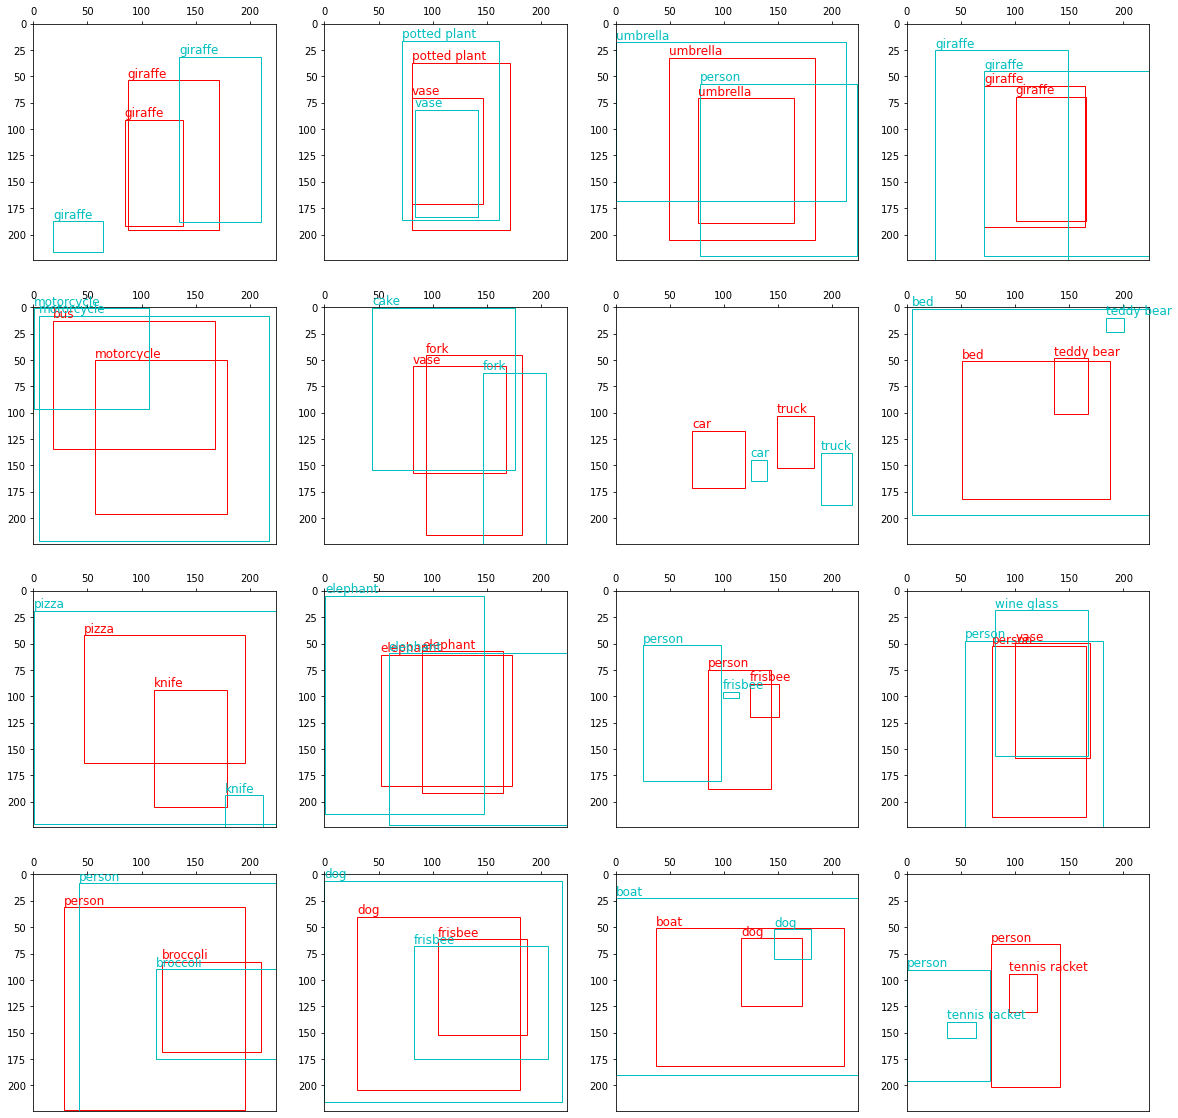

In [7]:
# text2bboxs
# batch = next(iter(dataloader))
#  'a woman standing on skiis while posing for the camera',
#  'A white oven and a white refrigerator are in the kitchen.',
#  'part of a sandwich sitting on a table',
#  'A paddle boarder on a large, still body of water.',
#  'A black fluffy cat sitting on top of a computer keyboard.',
#  "A baby giraffe drinking milk from it's mother in a field.",
#  'A white bowl of green granny smith apples.',
#  'The boy is looking back at a wave in the ocean. ']
text = [
#         'cat and dog.',
#         'a man with a dog.',
#         'a horse standing by a tree.',
#         'a woman having dinner.',
#         'a photo of the bathroom.', 
#         'a picture of a kitchen.',
        'two same and identical farm animals.',
        'two different farm animals.',
        "a picture of two animals.",
        "a picture of two animals that is human's best friend.",
#         "a picture of two furry animals that eat mouses.",
#         'a picture of some farm animals except cow.',
    
        'a picture of some wild animals.',
        'a picture of some different wild animals.',
        'a picture of some transports.',
        'a picture of some transports that can fly.',

        'part of a sandwich sitting on a table',
        'part of a sandwich sitting under a table',
        'a woman standing on a chair.',
        'a woman standing on the left of a chair.',
    
#         'A paddle boarder on a large, still body of water.',
        'A cat sitting on top of a computer keyboard.',
        'A cat sitting under a computer keyboard.',
#         'a cat that is on the left in the photo.',
        'a picture where two cats are on the right.',
        'a picture where two cats are on the left.'
#         'A cat sitting on the right of a computer keyboard.',
#         'A cat sitting on the left of a computer keyboard.',
#         'A black fluffy cat sitting on top of a computer keyboard.',
#         'A black fluffy cat sitting under a computer keyboard.',
#         "A baby giraffe drinking milk from it's mother in a field.",
#         'A white bowl of green granny smith apples.',
#         'The boy is looking back at a wave in the ocean. '
]
# batch = next(dataloader)
text = []
# text += [t[0] for t in batch['clip_texts'][:16]]

text_feats = [clip.tokenize(t).cuda() for t in batch['clip_texts'][:16]]
print(text_feats[0].shape, len(text_feats)) # (5, 77)

text_feats = [model.clip_model.encode_text(t).mean(dim=0) for t in text_feats]
text_feats = torch.stack(text_feats).float()
print(text_feats.shape)
# text_feats = clip.tokenize(text).to('cuda')
# text_feats = model.clip_model.encode_text(text_feats).float()

model.eval()
with torch.no_grad():
    batch.update(model.generate(text_feats))
    
    out_cats = model.feat2cat(batch, cat_texts)
    out_cats = [[cat_texts[j.item()] for j in i] for i in out_cats]


plt.figure(figsize=(20, 20))
color = ('r', 'c')
for num_img in range(16):
    plt.subplot(4,4,num_img+1)
#     plt.title(text[num_img], size=11)
    plt.xlim(0, 224)
    plt.ylim(0, 224)
    
    plt.gca().xaxis.set_ticks_position('top') #将x轴的位置设置在顶部
    plt.gca().invert_yaxis()
#     plt.gca().invert_yaxis()
#     plt.gca().invert_yaxis()
        
    for j in range(batch['output_bboxs'].shape[1]):
        [bbox_x, bbox_y, bbox_w, bbox_h] = torch.clamp(batch['output_bboxs'][num_img][j].cpu(), 0, 1)
        plt.gca().add_patch(plt.Rectangle((bbox_x*224, bbox_y*224), bbox_w*224, bbox_h*224, 
                                          fill=False, color='r', linewidth=1))
        plt.text(bbox_x*224, bbox_y*224-3, out_cats[num_img][j], color='r', size=12)
        
    for j in range(batch['bboxs'].shape[1]):
        [bbox_x, bbox_y, bbox_w, bbox_h] = torch.clamp(batch['bboxs'][num_img][j].cpu(), 0, 1)
        plt.gca().add_patch(plt.Rectangle((bbox_x*224, bbox_y*224), bbox_w*224, bbox_h*224, 
                                          fill=False, color='c', linewidth=1))
        plt.text(bbox_x*224, bbox_y*224-3, batch['cat_name'][num_img][j], color='c', size=12)
    
#     plt.imshow(batch['clip_images'][num_img].permute(1,2,0).cpu())
#     plt.title('\n'.join(out_cats[num_img]), color='white')

In [8]:
text

[]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

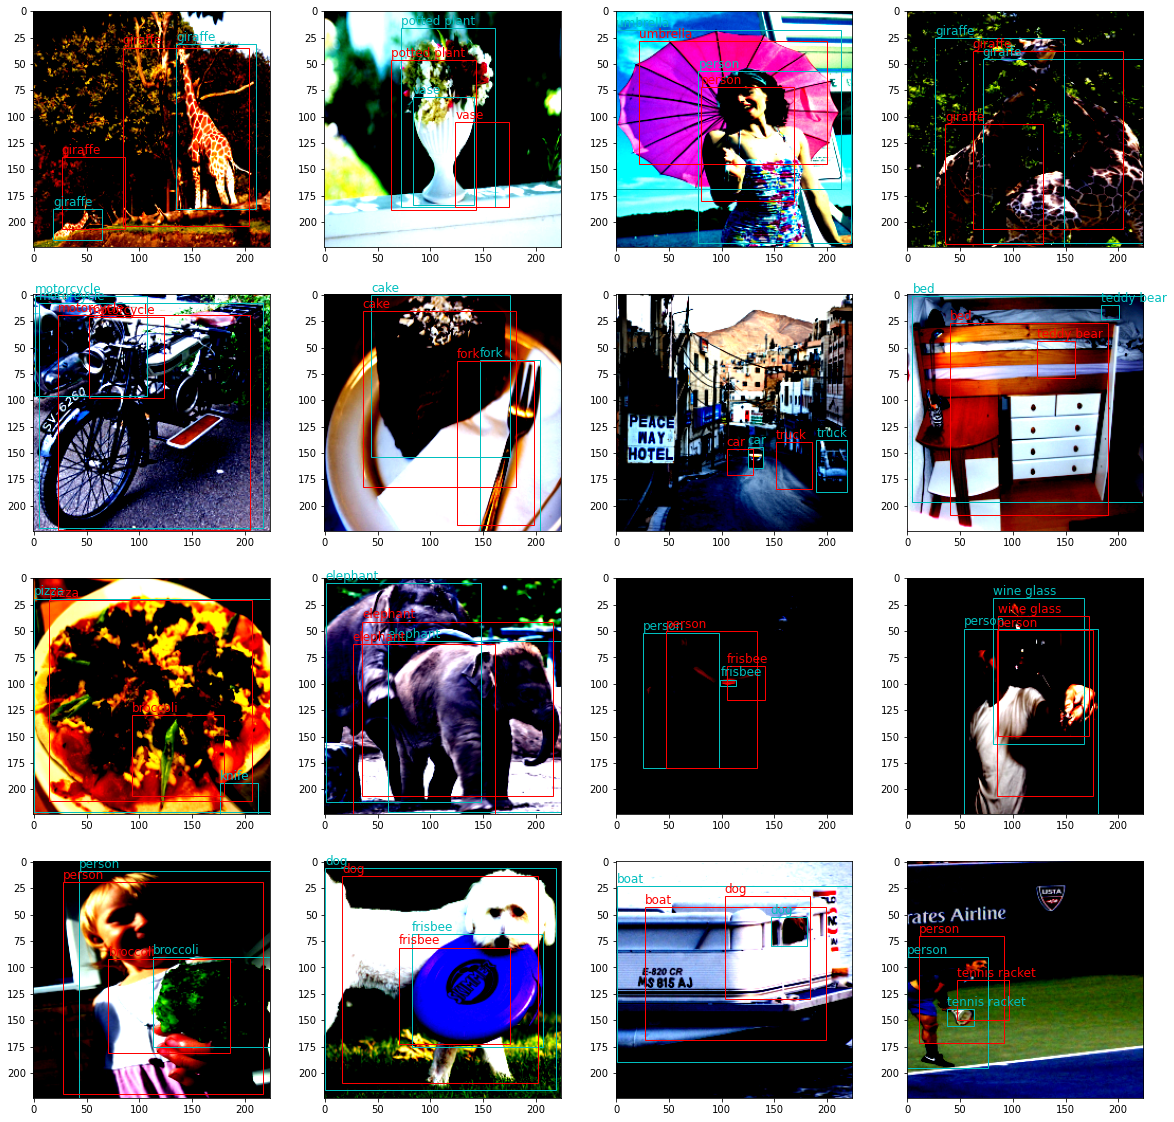

In [9]:
# image2bboxs
# batch = next(iter(dataloader))
for k, v in batch.items():
    if torch.is_tensor(v): batch[k] = batch[k].to('cuda')

model.eval()
image_feats = model.clip_model.encode_image(batch['clip_images']).float()
with torch.no_grad():
    batch.update(model.generate(image_feats))
    
    out_cats = model.feat2cat(batch, cat_texts)
    out_cats = [[cat_texts[j.item()] for j in i] for i in out_cats]

plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(batch['clip_images'][i].permute(1,2,0).cpu())
    for j in range(batch['bboxs'].shape[1]):
        [bbox_x, bbox_y, bbox_w, bbox_h] = batch['bboxs'][i][j].cpu()
#         print(bbox_x, bbox_y, bbox_w, bbox_h)
        plt.gca().add_patch(plt.Rectangle((bbox_x*224, bbox_y*224), bbox_w*224, bbox_h*224, 
                                          fill=False, edgecolor='c', linewidth=1))
        plt.text(bbox_x*224, bbox_y*224-3, batch['cat_name'][i][j], color='c', size=12)
    
    for j in range(batch['output_bboxs'].shape[1]):
        [bbox_x, bbox_y, bbox_w, bbox_h] = torch.clamp(batch['output_bboxs'][i][j].cpu(), 0, 1)
        plt.gca().add_patch(plt.Rectangle((bbox_x*224, bbox_y*224), bbox_w*224, bbox_h*224, 
                                          fill=False, edgecolor='r', linewidth=1))
        plt.text(bbox_x*224, bbox_y*224-3, out_cats[i][j], color='r', size=12)